In [42]:
%reload_ext autoreload
%autoreload 2


In [124]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'DEBUG',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

#!pip install dowhy
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygraphviz

### Step-1. Create a Causal Graph

In [95]:
df = pd.read_csv('loans_causal_schema.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   emp_length                     9183 non-null   float64
 1   state                          10000 non-null  object 
 2   homeownership                  10000 non-null  object 
 3   annual_income                  10000 non-null  float64
 4   debt_to_income                 9976 non-null   float64
 5   delinq_2y                      10000 non-null  int64  
 6   earliest_credit_line           10000 non-null  int64  
 7   inquiries_last_12m             10000 non-null  int64  
 8   total_credit_lines             10000 non-null  int64  
 9   open_credit_lines              10000 non-null  int64  
 10  total_credit_limit             10000 non-null  int64  
 11  total_credit_utilized          10000 non-null  int64  
 12  total_collection_amount_ever   10000 non-null  

In [101]:
#remove unneccessary fields
df.drop(['open_credit_lines', 'total_credit_lines', 
         'total_credit_utilized', 'total_credit_limit',
         'num_accounts_120d_past_due','num_accounts_30d_past_due',
         'num_open_cc_accounts','num_total_cc_accounts',
         ], axis=1, inplace=True)

df.drop(['account_never_delinq_percent','delinq_2y','earliest_credit_line','total_collection_amount_ever',
         'accounts_opened_24m','public_record_bankrupt','num_accounts_past_due','inquiries_last_12m'], axis=1, inplace=True)
df.drop(['loan_status','homeownership'], axis=1, inplace=True)

In [111]:
df.isnull().sum()

emp_length                       0
state                            0
annual_income                    0
debt_to_income                   0
num_satisfactory_accounts        0
num_active_debit_accounts        0
total_debit_limit                0
num_cc_carrying_balance          0
num_mort_accounts                0
loan_amount                      0
term                             0
interest_rate                    0
installment                      0
balance                          0
paid_total                       0
credit_line_utilization          0
credit_utilization               0
cc_utilization                   0
delinquent_history               0
credit_duration                  0
has_credit_inquiries_last_12m    0
has_collection_accounts          0
has_accounts_opened_24m          0
has_bankrupt_history             0
has_past_due_accounts            0
debt_limit_exceded               0
is_bad_loan                      0
is_homeowner                     0
dtype: int64

In [110]:
# we have to remove/fix missing values
df['debt_to_income'] = df['debt_to_income'].interpolate()
df['credit_utilization'] = df['credit_utilization'].interpolate()
df  = df.dropna()

### Step-1. Create a Causal Graph


#### In this step we will make assumptions and domain knowledge applied to causal graph
Here are a list of assumptions that have then been translated into a Causal Diagram


* employment length, state, homeownership status and annual income play a major role in deciding the status of the loan

* length of employment and the state where borrower lives will definitley affect the anual income.  

* homeownership status will play a role in how many mortgage accounts a borrower will have

* In real world, credit duration is usually an indication of the employment duration ('emp_length'-->'credit_duration')

* 'has_bankrupt_history' --> 'has_credit_inquiries_last_12m'

* 'debt_limit_exceded', 'has_past_due_accounts', 'has_collection_accounts', 'delinquent_history' --> 'has_bankrupt_history'

* 'has_bankrupt_history', 'delinquent_history' --> 'is_bad_loan'

* 'credit_line_utilization','credit_utilization', 'cc_utilization' --> 'is_bad_loan'

* 'emp_length' --> 'total_debit_limit'

* 'annual_income' --> 'credit_line_utilization','credit_utilization', 'cc_utilization'


'emp_length', 'state', 'homeownership', 'annual_income',
       'debt_to_income', 'num_satisfactory_accounts',
       'num_active_debit_accounts', 'total_debit_limit',
       'num_cc_carrying_balance', 'num_mort_accounts', 'loan_amount', 'term',
       'interest_rate', 'installment', 'balance', 'paid_total',
       'credit_line_utilization_%', 'credit_utilization_%', 'cc_utilization_%',
       'delinquent_history', 'credit_duration',
       'has_credit_inquiries_last_12m', 'has_collection_accounts',
       'has_accounts_opened_24m', 'has_bankrupt_history',
       'has_past_due_accounts', 'debt_limit_exceded', 'is_bad_loan'

In [126]:
file = open("causal_graph_is_homeowner.dot")
causal_graph = file.read().replace("\n", " ")
file.close()

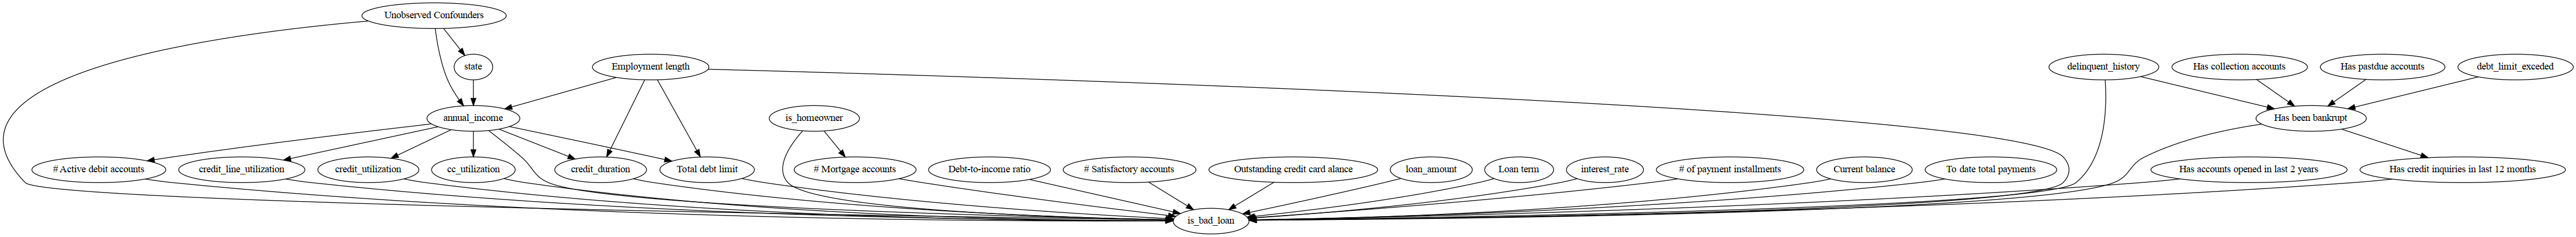

In [127]:
model= dowhy.CausalModel(
        data = df,
        graph=causal_graph,
        treatment='is_homeowner',
        outcome='is_bad_loan')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png",width = 5000, height = 100))

### Step-2. Identify the Causal Effect

In [128]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
────────────────(Expectation(is_bad_loan|num_satisfactory_accounts,has_collect
d[annual_income]                                                              

                                                                              
ion_accounts,state,paid_total,balance,installment,interest_rate,term,delinquen
                                                                              

                                                                              
t_history,has_accounts_opened_24m,emp_length,num_mort_accounts,loan_amount,has
                                                                              

                                                                              
_past_due_accounts,has_credit_inquiries_last_12m,num_cc_carrying_balance,has_b
                                

### Step-3. Estimate the identified estimand

In [115]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(Expectation(is_bad_loan|num_satisfactory_accounts,credit_line_
d[is_homeowner]                                                               

                                                                              
utilization,has_collection_accounts,state,cc_utilization,paid_total,num_active
                                                                              

                                                                              
_debit_accounts,balance,installment,interest_rate,term,delinquent_history,has_
                                                                              

                                                                              
accounts_opened_24m,emp_length,credit_utilization,loan_amount,t

/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


### Step-4. Refute results

##### Radom Common Cause:
Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.

In [116]:
refuter1=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(refuter1)

/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


Refute: Add a Random Common Cause
Estimated effect:-0.015157970549778075
New effect:-0.015368258746644398



#### Placebo Treatment Refuter:
Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

In [122]:
refuter2=model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                              placebo_type="permute", num_simulations=5)
print(refuter2)

/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/

Refute: Use a Placebo Treatment
Estimated effect:-0.015157970549778075
New effect:0.0007681529974696684
p value:0.4042689777819958



/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


#### Data Subset Refuter:
Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

In [119]:
refuter3=model.refute_estimate(identified_estimand, estimate,  method_name="data_subset_refuter")
print(refuter3)

/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/

/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/

/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/

/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/

Refute: Use a subset of data
Estimated effect:-0.015157970549778075
New effect:-0.00786721652238142
p value:0.02



/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


#### Bootstrap Refuter:
Refute an estimate by running it on a random sample of the data containing measurement error in the confounders. This allows us to find the ability of the estimator to find the effect of the treatment on the outcome.


In [125]:
refuter4=model.refute_estimate(identified_estimand, estimate,  method_name="bootstrap_refuter", num_simulations=5)
print(refuter4)

/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
/

Refute: Bootstrap Sample Dataset
Estimated effect:-0.015157970549778075
New effect:-0.009889016964851284
p value:0.1924310415705872



/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]
